## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/home/nassim/dev/mlops-project/training'

In [2]:
from src.utils import *
from src.models import *
from src.data import *

import wandb
import numpy as np
import matplotlib.pyplot as plt
import torch

from pathlib import Path

In [3]:
set_device(cuda=True)

device(type='cuda')

## Fashion MNIST Dataset

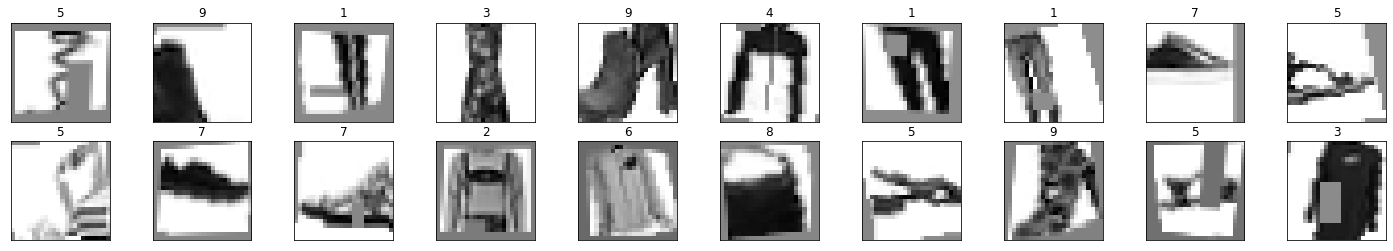

In [4]:
%%capture --no-display
batch_size = 128
num_classes = 10

transforms_args = {"random_crop": True, "random_erasing": True, "random_perspective": True, "random_affine": True}
dm = FashionDataModule(num_classes=num_classes, transforms_args=transforms_args)
dm.setup()

dataiter = iter(dm.train_dataloader(batch_size=batch_size, num_workers=4))
images, labels = dataiter.next()

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
    ax.set_title("{}".format(str(labels[idx].item())))

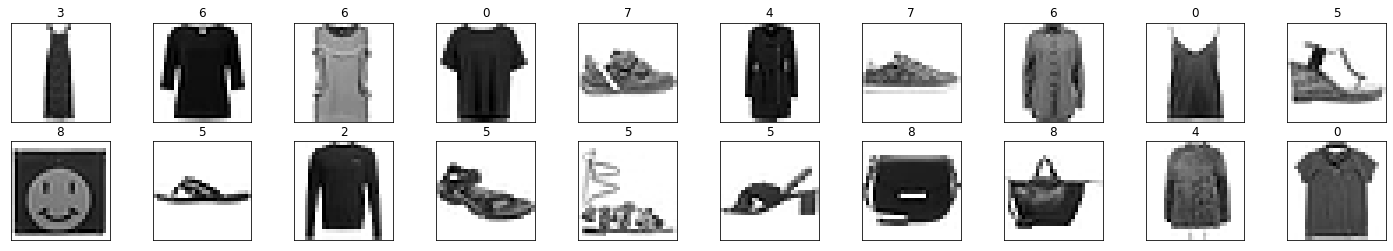

In [5]:
%%capture --no-display
batch_size = 128
num_classes = 10

dm = FashionDataModule(num_classes=num_classes)
dm.setup()

dataiter = iter(dm.train_dataloader(batch_size=batch_size, num_workers=4))
images, labels = dataiter.next()

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
    ax.set_title("{}".format(str(labels[idx].item())))

In [6]:
n = len(dm.train)+len(dm.val)+len(dm.test)

print("Dataset split:\n"+
    "Train: {:.2f}\n".format(len(dm.train)/n)+
    "Val: {:.2f}\n".format(len(dm.val)/n)+
    "Test: {:.2f}\n".format(len(dm.test)/n)
    )

Dataset split:
Train: 0.73
Val: 0.13
Test: 0.14



In [7]:
# %%capture --no-display
# loader = dm.train_dataloader(batch_size=batch_size, num_workers=4)
# mean = 0.
# std = 0.
# for images, _ in loader:
#     batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)

# mean /= len(loader.dataset)
# std /= len(loader.dataset)
# print(mean, std)

In [8]:
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [9]:
# Checking class weights
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# num_classes = len(class_names)

# y_train = dm.train.dataset.targets
# counts = np.bincount(y_train)
# class_weights = {i: 1.0/count for i, count in enumerate(counts)}
# print (f"counts: {counts}\nweights: {class_weights}")

## Custom Fashion Products Dataset

In [20]:
raw_csv_file = "data/datasets/fashion-products-small/styles.csv"
root_dir = "data/datasets/fashion-products-small/images"

df = pd.read_csv(raw_csv_file, on_bad_lines="skip")
# Some processing
df = df[['id','masterCategory']]
df.columns = ["image_id", "label"]
df = df.astype("string")

counts = df['label'].value_counts()
df = df[~df['label'].isin(counts[counts < 20].index)]
df.dropna()

no_match = []
for idx, row in df.iterrows():
    image_id = row["image_id"]
    path = root_dir + "/" + image_id + ".jpg"
    if not Path(path).is_file():
        no_match.append(idx)

df.drop(no_match, inplace=True)
df.to_csv(path_or_buf="data/datasets/fashion-products-small/preprocessed_labels.csv", index=False)

In [11]:
csv_file = "data/datasets/fashion-products-small/preprocessed_labels.csv"
root_dir = "data/datasets/fashion-products-small/images"

ds = FashionDataset(csv_file, root_dir)
ds[0]

(<PIL.Image.Image image mode=RGB size=60x80 at 0x7F2FE21CDF70>, 1)

In [12]:
# Classes weights, heavily unbalanced dataset!
ds.df.label.value_counts(normalize=True)

Apparel           0.481665
Accessories       0.253787
Footwear          0.207528
Personal Care     0.054094
Free Items        0.002364
Sporting Goods    0.000563
Name: label, dtype: Float64

Some ideas:
* Oversampling minority classes...
* Merging similar classes (Free Items and Accessories)...
* Undersampling majority class...

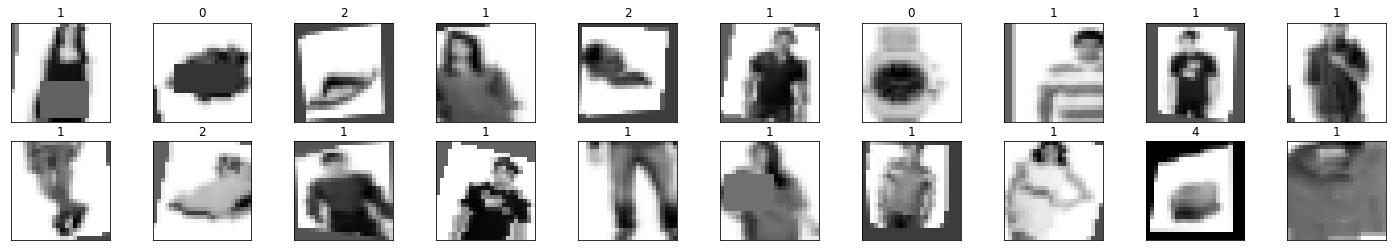

In [14]:
%%capture --no-display

batch_size = 64
num_classes = df["label"].nunique()

split = [0.7, 0.15, 0.15]
custom_ds_info = {
    "csv_file": csv_file,
    "ds_dir": root_dir,
    "split": split
}

transforms_args = {"random_crop": True, "random_erasing": True, "random_perspective": True, "random_affine": True}

dm = FashionDataModule(num_classes=num_classes, transforms_args=transforms_args, custom_ds_info=custom_ds_info)
dm.setup()

dataiter = iter(dm.train_dataloader(batch_size=batch_size, num_workers=4))
images, labels = dataiter.next()

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{}".format(str(labels[idx].item())))

In [15]:
n = len(dm.train)+len(dm.val)+len(dm.test)

print("Dataset split:\n"+
    "Train: {:.2f}\n".format(len(dm.train)/n)+
    "Val: {:.2f}\n".format(len(dm.val)/n)+
    "Test: {:.2f}\n".format(len(dm.test)/n)
    )

Dataset split:
Train: 0.70
Val: 0.15
Test: 0.15



## Training

In [16]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dodicin (use `wandb login --relogin` to force relogin)


True

In [17]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import ModelPruning
from pytorch_lightning.callbacks import QuantizationAwareTraining

num_classes=10
batch_size=128
model = ResNet18(num_classes=num_classes, fine_tune=True)
dm = FashionDataModule(num_classes=num_classes, batch_size=batch_size, num_workers=8)
dm.setup()

In [19]:
MODEL_CKPT_PATH = 'data/notebook_run/models/'
MODEL_CKPT = 'model-{epoch:02d}-{val_loss:.2f}'

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename=MODEL_CKPT,
    dirpath=MODEL_CKPT_PATH,
    save_top_k=3,
    mode='min')

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=False,
    mode='min'
)

pruning_callback = ModelPruning(
    pruning_fn="l1_unstructured", 
    amount=0.1, 
    verbose=1,
    use_global_unstructured=True
)

#quantization_callback = QuantizationAwareTraining() # Usable on another backend

run = wandb.init(project='mlops-project')
wandb_logger = WandbLogger(project='mlops-project', job_type='train', log_model=True)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=1,
                    auto_lr_find=True,
                    #auto_scale_batch_size="binsearch", # Do not use on WSL
                    gpus=1,
                    progress_bar_refresh_rate=20,
                    logger=wandb_logger,
                    callbacks=[early_stop_callback,
                            checkpoint_callback,
                            pruning_callback,
                            ImagePredictionLogger()
                            ],
                    checkpoint_callback=True,
                    fast_dev_run = False
                    )

# Experiment identifiers
run_id = trainer.logger.experiment.id
project = trainer.logger.experiment.project
entity = trainer.logger.experiment.entity

trainer.tune(model, datamodule=dm)

wandb.config.update({"learning_rate": model.learning_rate})
trainer.fit(model, dm)
trainer.test(ckpt_path="best")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/nassim/miniconda3/envs/fashion-testing/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params
-------------------------------------------------------
0 | accuracy          | Accuracy         | 0     
1 | loss              | CrossEntropyLoss | 0     
2 | feature_extractor | ResNet           | 11.7 M
3 | classifier        | Linear           | 10.0 K
-------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.763    Total estimated model params size (MB)
/home/nassim/miniconda3/envs/fashion-testing/l

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 86 steps due to diverging loss.
Restoring states from the checkpoint file at /home/nassim/dev/mlops-project/training/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/nassim/dev/mlops-project/training/lr_find_temp_model.ckpt
Learning rate set to 0.00012022644346174131


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f2fe30b7400>}

In [ ]:
best_model = trainer.checkpoint_callback.best_model_path # Getting checkpoint ref from PL
inference_model = ResNet18.load_from_checkpoint(best_model)
y_true, y_pred = evaluate(inference_model, dm.test_dataloader())

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve

binary_ground_truth = label_binarize(y_true,
                                     classes=np.arange(0, 10).tolist())

precision_micro, recall_micro, _ = precision_recall_curve(binary_ground_truth.ravel(),
                                                          y_pred.ravel())

In [ ]:
data = [[x, y] for (x, y) in zip(recall_micro, precision_micro)]
sample_rate = int(len(data)/10000)

table = wandb.Table(columns=["recall_micro", "precision_micro"], data=data[::sample_rate])
wandb.log({"precision_recall" : wandb.plot.line(table, 
                                                "recall_micro", 
                                                "precision_micro", 
                                                stroke=None, 
                                                title="Average Precision")})

wandb.finish()

## Inference time

In [ ]:
checkpoint_reference = f'{entity}/{project}/model-{run_id}:best' # Checkpoint ref from WandB
run = wandb.init(project='mlops-project')
artifact = run.use_artifact(checkpoint_reference, type='model')
artifact_dir = artifact.download()
model = ResNet18.load_from_checkpoint(Path(artifact_dir)/'model.ckpt')

In [ ]:
mean_syn, std_syn = measure_inference_time([1, 28, 28], model)
print("Mean inference time: {:2f}+-{:2f}ms".format(mean_syn, std_syn))

In [ ]:
throughput = measure_throughput([1, 28, 28], model)
print('Inferences per second: {:2f}'.format(throughput))

## Export

In [4]:
# Find the best model from the WandB dashboard
api = wandb.Api()

artifact = api.artifact("mlops-project/model-14hj109q:best")
artifact_dir = artifact.checkout()

model = ResNet18.load_from_checkpoint(Path(artifact_dir)/'model.ckpt')
model.eval()

wandb: Downloading large artifact model-14hj109q:best, 133.91MB. 1 files... Done. 0:0:0


ResNet18(
  (accuracy): Accuracy()
  (loss): CrossEntropyLoss()
  (feature_extractor): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2

/home/nassim/miniconda3/envs/fashion-testing/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/nassim/miniconda3/envs/fashion-testing/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/co

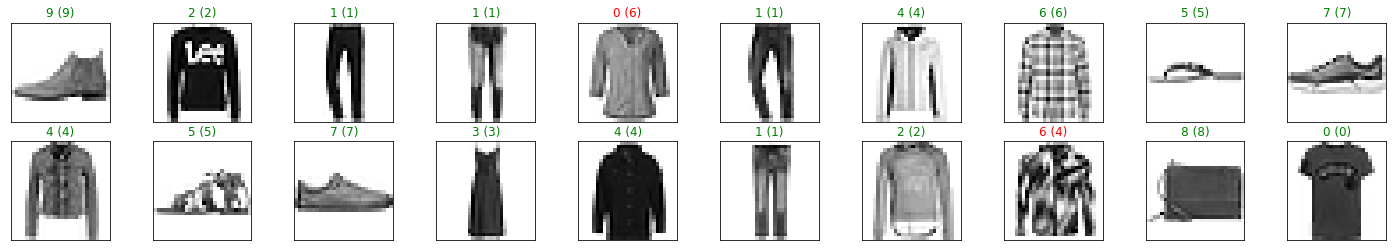

In [5]:
batch_size = 128
num_classes = 10
dm = FashionDataModule(num_classes=num_classes)
dm.setup()

dataiter = iter(dm.test_dataloader(batch_size=batch_size, num_workers=4))
images, labels = dataiter.next()

_, preds = model.predict(images)
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                color=("green" if preds[idx]==labels[idx] else "red"))

In [6]:
model.eval()
x = torch.randn(1, 1, 28, 28, requires_grad=True)
out = model(x)

# Export the model
torch.onnx.export(model,                     # model being run
                x,                         # model input (or a tuple for multiple inputs)
                "model.onnx",              # where to save the model (can be a file or file-like object)
                export_params=True,        # store the trained parameter weights inside the model file
                opset_version=10,          # the ONNX version to export the model to
                do_constant_folding=True,  # whether to execute constant folding for optimization
                input_names = ['input'],   # the model's input names
                output_names = ['output'], # the model's output names
                dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                            'output' : {0 : 'batch_size'}})

In [7]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

In [8]:
import onnxruntime as onnxrt

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

img = np.random.rand(*[1, 1, 28, 28]).astype("float32")
onnx_session= onnxrt.InferenceSession("model.onnx")
onnx_inputs = {onnx_session.get_inputs()[0].name: img}
onnx_output = onnx_session.run(None, onnx_inputs)
logits_onnx = onnx_output[0]
preds_onnx = np.argmax(logits_onnx)

logits_torch = model(torch.tensor(img))
np.testing.assert_allclose(to_numpy(logits_torch), logits_onnx, rtol=1e-03, atol=1e-05)
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
